# Reinforcement Learning for Optimizing Medication Dosage

This notebook demonstrates the application of reinforcement learning (RL) in optimizing the dosage of a medication over time to maximize patient health outcomes.

## Step 1: Import Libraries

In [ ]:
!pip install stable_baselines3
!pip install shimmy>=0.2.1
!pip install gymnasium==0.28.1

In [2]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import DQN

## Step 2: Define the Environment

We will create a custom environment to simulate the patient's response to different dosages of medication. The goal is to find an optimal policy that maximizes the patient's health.

In [3]:
class MedicationEnv(gym.Env):
    def __init__(self):
        super(MedicationEnv, self).__init__()

        # Define action and observation space
        # Action: dosage level (0, 1, 2, 3, 4)
        self.action_space = spaces.Discrete(5)

        # Observation: patient health state (continuous value)
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)

        self.state = None
        self.steps_beyond_done = None

    def reset(self):
        # Initialize state (health state)
        self.state = np.array([0.5], dtype=np.float32)
        self.steps_beyond_done = None
        return self.state

    def step(self, action):
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        state = self.state[0]

        # Medication effect: simplistic model
        # Too high or too low dosage will decrease health
        if action == 0:
            state -= 0.05  # underdose
        elif action == 1:
            state += 0.01  # slight underdose
        elif action == 2:
            state += 0.05  # optimal dose
        elif action == 3:
            state += 0.01  # slight overdose
        elif action == 4:
            state -= 0.05  # overdose

        # Add some random fluctuation
        state += np.random.normal(0, 0.01)

        # Bound the state to [0, 1]
        state = np.clip(state, 0, 1)
        self.state = np.array([state], dtype=np.float32)

        # Define reward
        reward = state

        # Episode is done if health is 0 or 1
        done = bool(state == 0 or state == 1)

        return self.state, reward, done, {}

    def render(self, mode='human'):
        pass

    def close(self):
        pass

## Step 3: Train the RL Agent

We will use the DQN (Deep Q-Network) algorithm from the `stable-baselines3` library to train our agent.

In [4]:
# Create environment
env = MedicationEnv()

# Define the model
model = DQN('MlpPolicy', env, verbose=1)

# Train the agent
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44       |
|    ep_rew_mean      | 15.7     |
|    exploration_rate | 0.833    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 492      |
|    time_elapsed     | 0        |
|    total_timesteps  | 176      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.122    |
|    n_updates        | 18       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.8     |
|    ep_rew_mean      | 17.8     |
|    exploration_rate | 0.622    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 539      |
|    time_elapsed     | 0        |
|    total_timesteps  | 398      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0767   |
|    n_updates      

## Step 4: Evaluate the Agent

We will evaluate the trained agent by running it in the environment and observing the outcomes.

In [5]:
# Evaluate the agent
episodes = 5
for episode in range(1, episodes + 1):
    state = env.reset()
    done = False
    step = 0
    while not done:
        action = model.predict(state, deterministic=True)[0]
        state, reward, done, info = env.step(action)
        step += 1
    print(f"Episode {episode}: {step} steps")

Episode 1: 10 steps
Episode 2: 10 steps
Episode 3: 10 steps
Episode 4: 11 steps
Episode 5: 10 steps


## Step 5: Visualize the Results

Let's plot the health state over time for one episode to see how the agent's actions affect the patient's health.

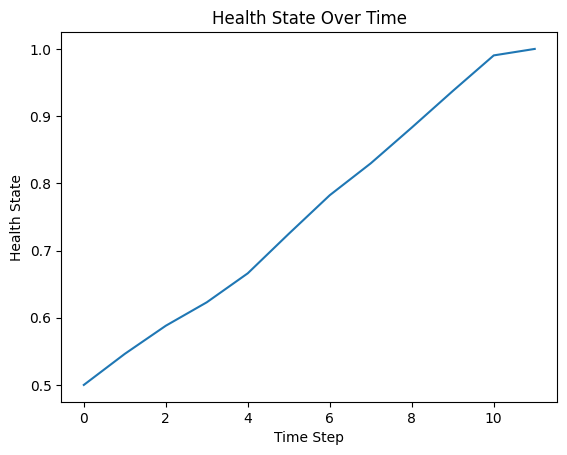

In [6]:
state = env.reset()
done = False
health_states = [state[0]]
while not done:
    action = model.predict(state, deterministic=True)[0]
    state, reward, done, info = env.step(action)
    health_states.append(state[0])

plt.plot(health_states)
plt.xlabel('Time Step')
plt.ylabel('Health State')
plt.title('Health State Over Time')
plt.show()